In [16]:
import sys
sys.path.append("../utils")
import os
import data_generation_and_treatment as dgen
import d2p2_sequence_analysis as d2p2
import cluster_tools as ct

import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

In [11]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True
# plt.rcParams.update({'figure.autolayout': True})

## Reduce dimensionality of data matrix

### Plot eigenvalue spectrum and percent variance explained

In [12]:
def plot_eigenvalue_plot(data_matrix, write_path, filename, clean_threshold=2.0):
    
    fig, axes = plt.subplots()
    # make_nice_axis(axes)
    q = data_matrix.iloc[:,:-1].values.shape[0]/(data_matrix.iloc[:,:-1].values.shape[1])
    lambda_max = 1 + 1/q + 2/q**0.5;
    # print('Eigen values greater than 2*{} are {}'.format(lambda_max,np.where(eig_vals<2*lambda_max)[0][0]))
    axes.plot(range(1, len(eig_vals)+1), eig_vals, color='black', marker='o')
    axes.plot(range(1, len(eig_vals)+1), lambda_max*np.ones(len(eig_vals)), color='grey', linestyle='--')
    axes.set_xscale('log')
    axes.set_xlabel('Index of eigenvalue')
    axes.set_ylabel('Magnitude of eigen value')
    plt.show()
    plt.savefig(os.path.join(write_path, filename + '_eigenvalue_spectrum.png'), format='png', dpi=600)
    plt.savefig(os.path.join(write_path, filename + '_eigenvalue_spectrum.svg'), format='svg', dpi=600)
    
    top_relevant_eigenvalues = np.where(eig_vals < 2*1.2)[0][0]
    fig,axes =plt.subplots()
    axes.plot(range(1,len(eig_vals)+1), np.cumsum(eig_vals)/sum(eig_vals)*100, color='black')
    axes.plot(range(1,len(eig_vals)+1), 
              np.ones(len(eig_vals))*np.sum(eig_vals[0:top_relevant_eigenvalues])/sum(eig_vals)*100, 
              color='grey', linestyle='--')
    axes.set_xscale('log')
    axes.set_xlabel('Index of eigenvalue')
    axes.set_ylabel('% variance explained')
    plt.savefig(os.path.join(write_path, filename + '_percent_variance_explained.png'), format='png', dpi=600)
    plt.savefig(os.path.join(write_path, filename + '_percent_variance_explained.svg'), format='svg', dpi=600)

### Get top n features with highest loadings in first PC

In [14]:
def plot_top_n_features(eig_vecs, data_matrix, top_n_features = 10):

    key = np.argsort((abs(eig_vecs[:, 0])))[::-1]
    weights_in_first_PC = abs(eig_vecs[key[0:top_n_features], 0])
    features = data_matrix.columns[key][0:top_n_features]

    fig, axes = plt.subplots()
    # make_nice_axis(axes)
    axes.bar(features, weights_in_first_PC)
    axes.set_xlabel('Feature name', fontsize=20)
    axes.set_ylabel('Weight in the first PC')
    plt.savefig(os.path.join(write_path, filename + '_top_features_in_PC1.png'), format='png', dpi=600)
    plt.savefig(os.path.join(write_path, filename + '_top_features_in_PC1.svg'), format='svg', dpi=600)

### Convert embeddings in pickle file to data matrix

In [34]:
def pkl_to_data_matrix(input_file, output_file):
    
    data = {}
    with open(input_file, 'rb') as file_in:
        data = pkl.load(file_in)
    
    with open(output_file, 'w') as file_out:
        header_flag = 1
        for sequence_id in data.keys():
            if header_flag:
                file_header = 'sequence id,'
                file_header += ','.join(['E_{}'.format(index+1) for index in range(len(data[sequence_id]))])
                file_out.write(file_header + '\n')
                header_flag = 0
            out_list = [str(sequence_id)] + [str(entry) for entry in data[sequence_id]]
            file_out.write(','.join(out_list) + '\n')

## Analyze kmer frequency data

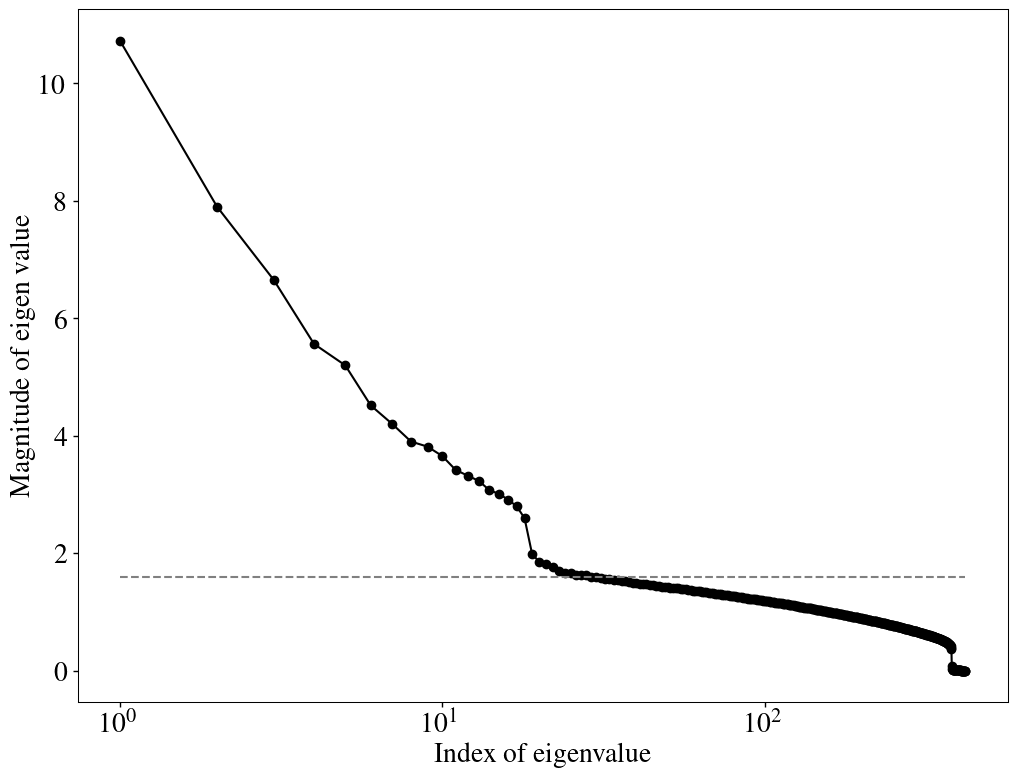

<Figure size 1200x900 with 0 Axes>

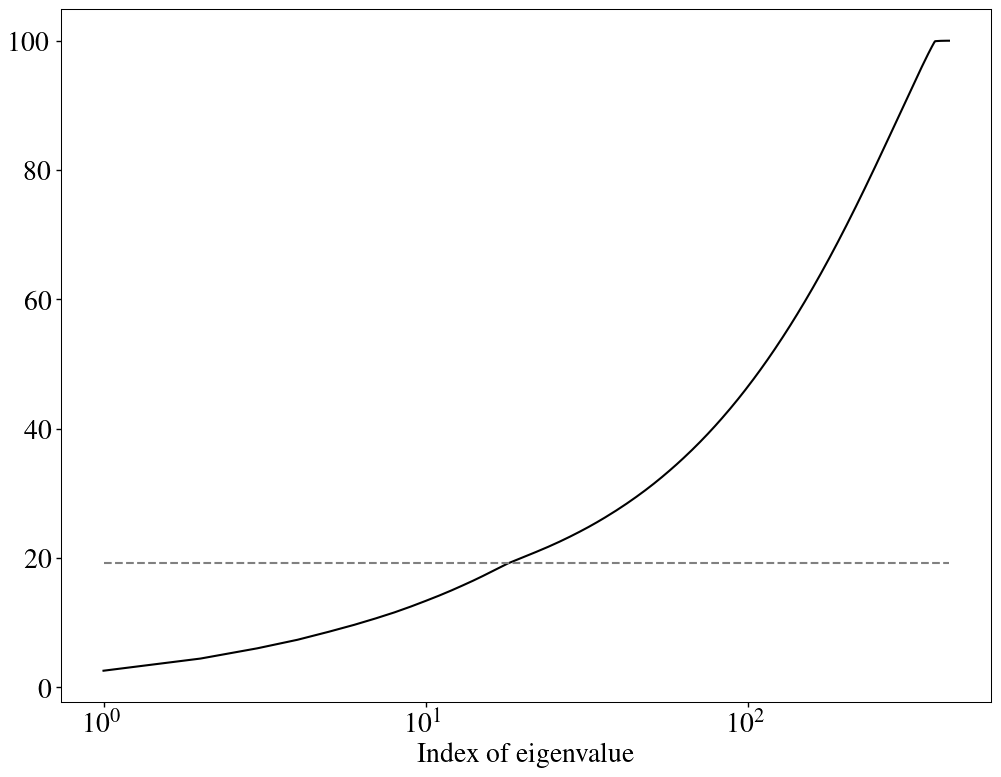

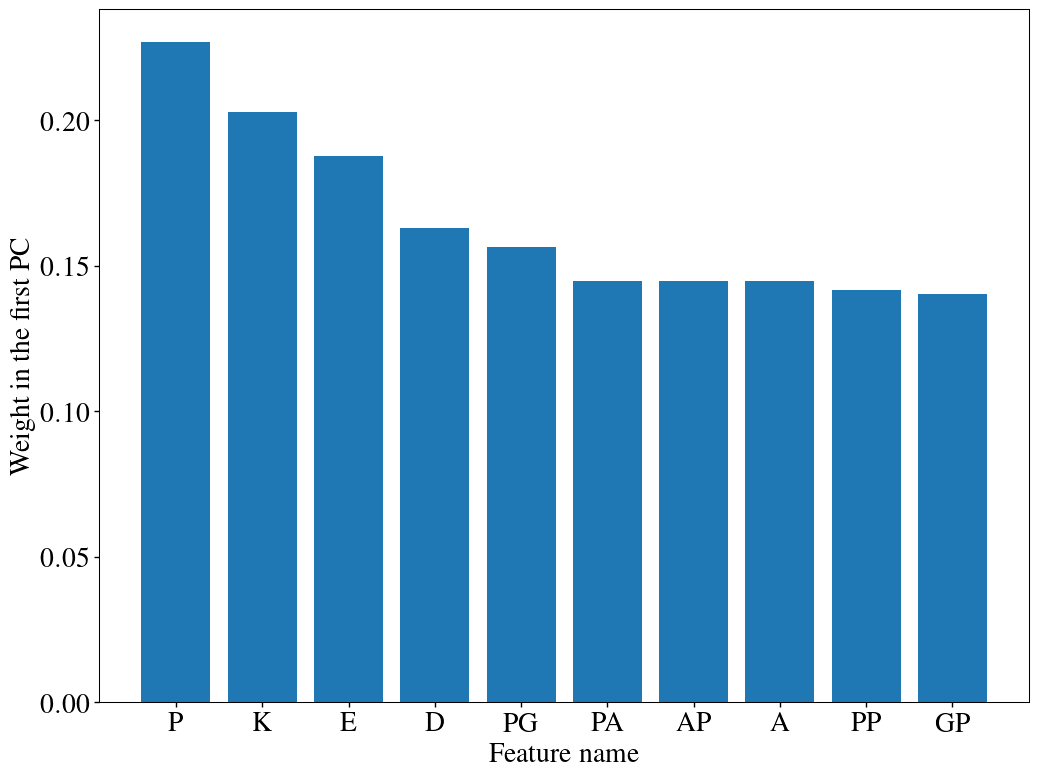

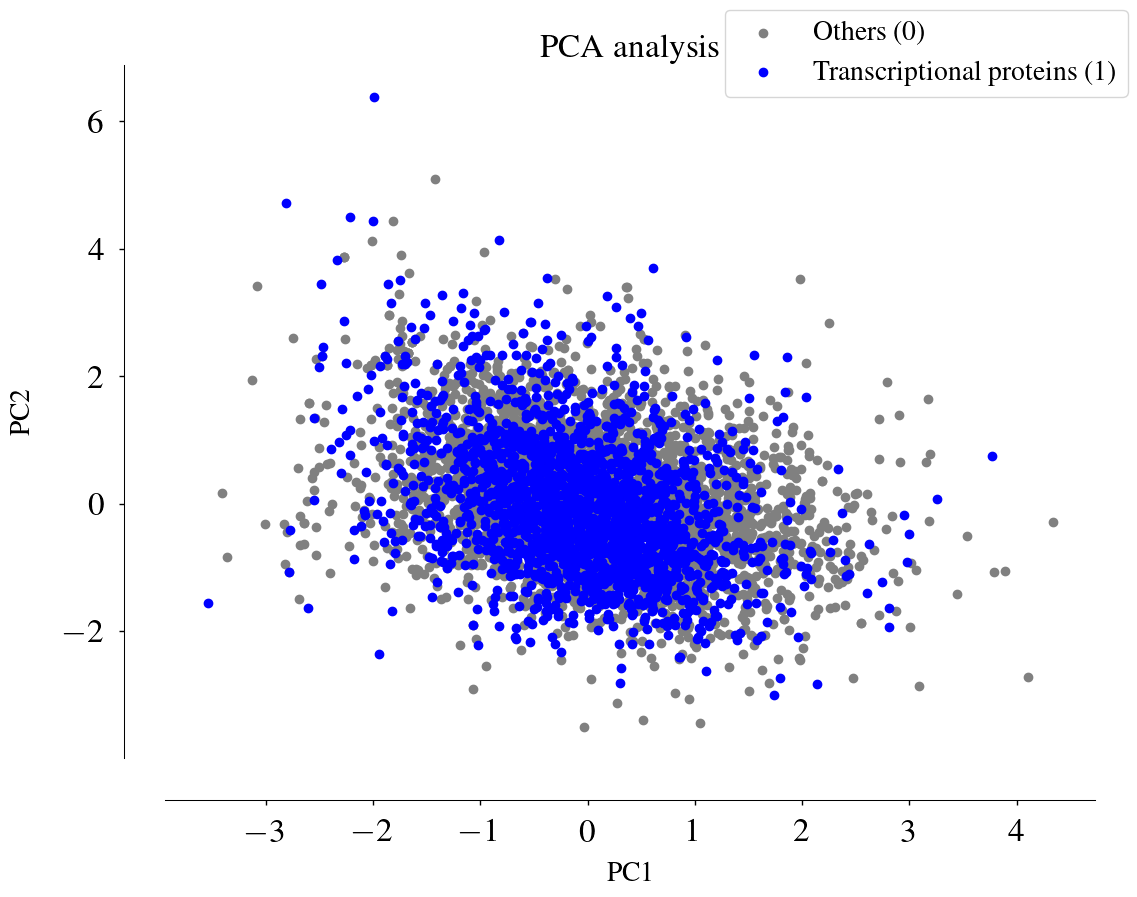

In [10]:
input_file = '../data/featurized_data_matrix/featurization_composition_mathfeatures/kmer_frequency_with_labels.csv'
write_path = '../data/featurized_data_matrix/featurization_composition_mathfeatures/kmer_frequency_PCA'
filename = 'kmer_frequency'

data_matrix = pd.read_csv(input_file)
# Drop the first column as it just contains the sequence names
data_matrix.drop(data_matrix.columns[0], axis=1, inplace=True)
# Convert the labels of 1 (transcription factors) and 2 (coactivators) into just 1
data_matrix.iloc[:,-1] = data_matrix.iloc[:,-1] > 0

# Dimensionality reduction
(eig_vals, eig_vecs, pc_scores)= ct.PCA_analysis(data_matrix.iloc[:, :-1].values,
                                                 centered=True,
                                                 clean_matrix=False,
                                                 clean_threshold=2.0,
                                                 write_PC_scores=True,
                                                 write_path=write_path)

# Plot eigenvalue spectrum and percent variance explained
plot_eigenvalue_plot(data_matrix, write_path=write_path, filename=filename)

# Plot the top few features in the first principal component
plot_top_n_features(eig_vecs=eig_vecs, data_matrix=data_matrix)

# Plot2D projection of data with labels
colors = ['grey','blue']
label_legends = ['Others (0)', 'Transcriptional proteins (1)']
ax = ct.plot_PCA(pc_scores,
                 T=data_matrix.iloc[:,-1],
                 pc_int1=0,
                 pc_int2=1,
                 colors=colors,
                 labels=label_legends,
                 file_save=1,
                 write_path=write_path+'/')

Directory ../data/featurized_data_matrix/featurization_composition_mathfeatures/kmer_frequency_PCA/clustering_results/Cluster_Purity_ already exists
[478. 549. 336. 509. 144. 436.  97.  43. 692.  60.  71. 492. 506. 228.
 308. 389. 474.  89. 224.  50.]
Directory ../data/featurized_data_matrix/featurization_composition_mathfeatures/kmer_frequency_PCA already exists


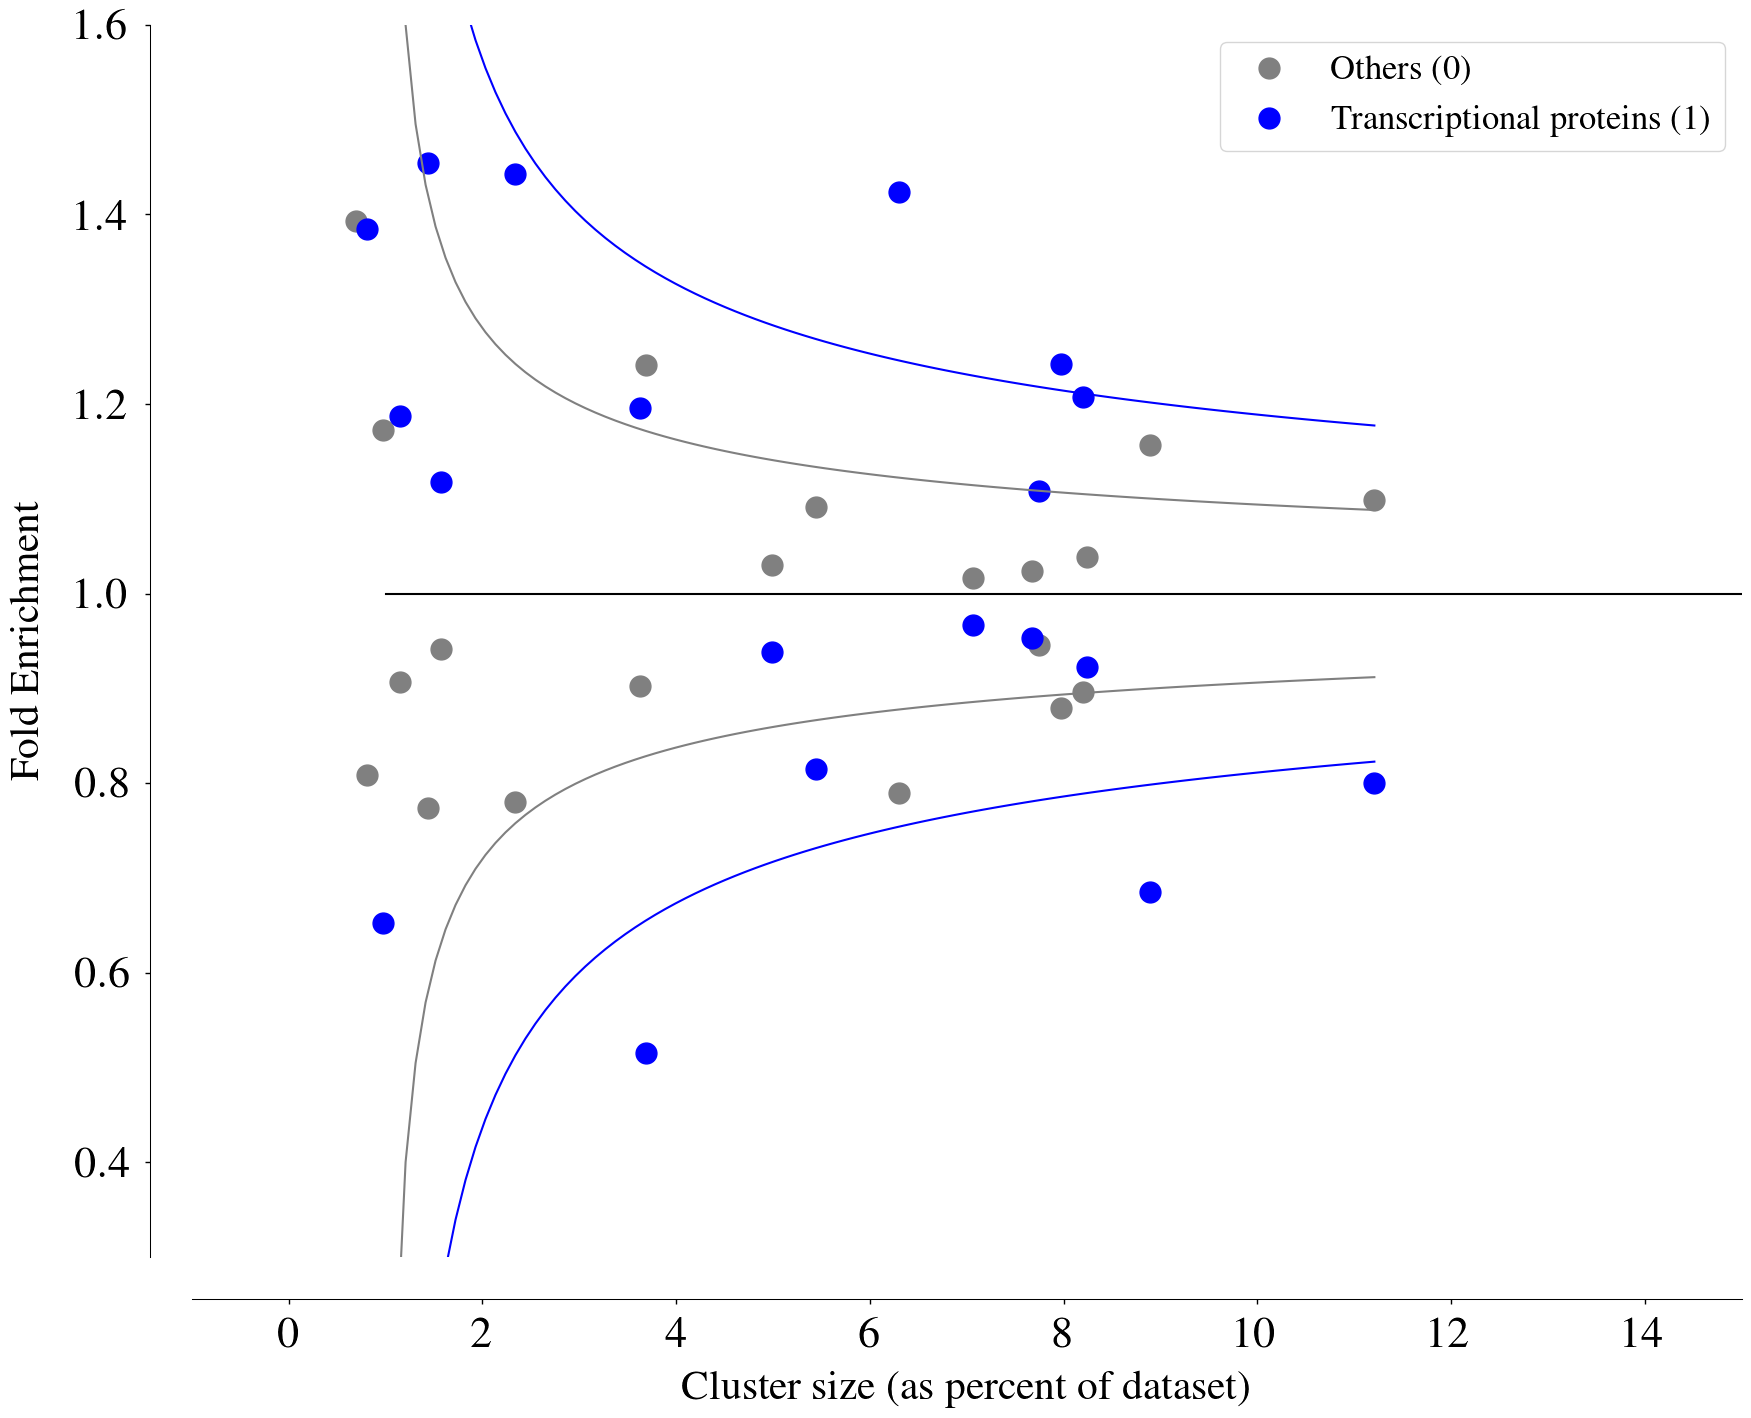

In [14]:
# Cluster the data and analyze cluster compositions

n_pcs = len(data_matrix.columns[:-1])
n_clusters = 20

labels = data_matrix.iloc[:,-1]

graph_labels = label_legends

xlim=(-1,15)
ylim=(0.3,1.6)

# Clustering after dim reduction using PCA:
clust_labels_PCA = dgen.cluster_reduced_matrix(pc_scores, labels, n_pcs, n_clusters, write_path, 1, 1)
# dgen.generate_purity_plots(write_file_path, graph_labels, flag_save_files, 1, n_pcs, n_clusters)
dgen.plot_enrichment_vs_cluster_size(write_path, '/' + filename + '_cluster_enrichment', 
                                     data_matrix, 
                                     labels, 
                                     graph_labels, 
                                     colors, xlim, ylim, 
                                     1, 1, n_pcs, n_clusters)

## Analysis of the original dataset

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


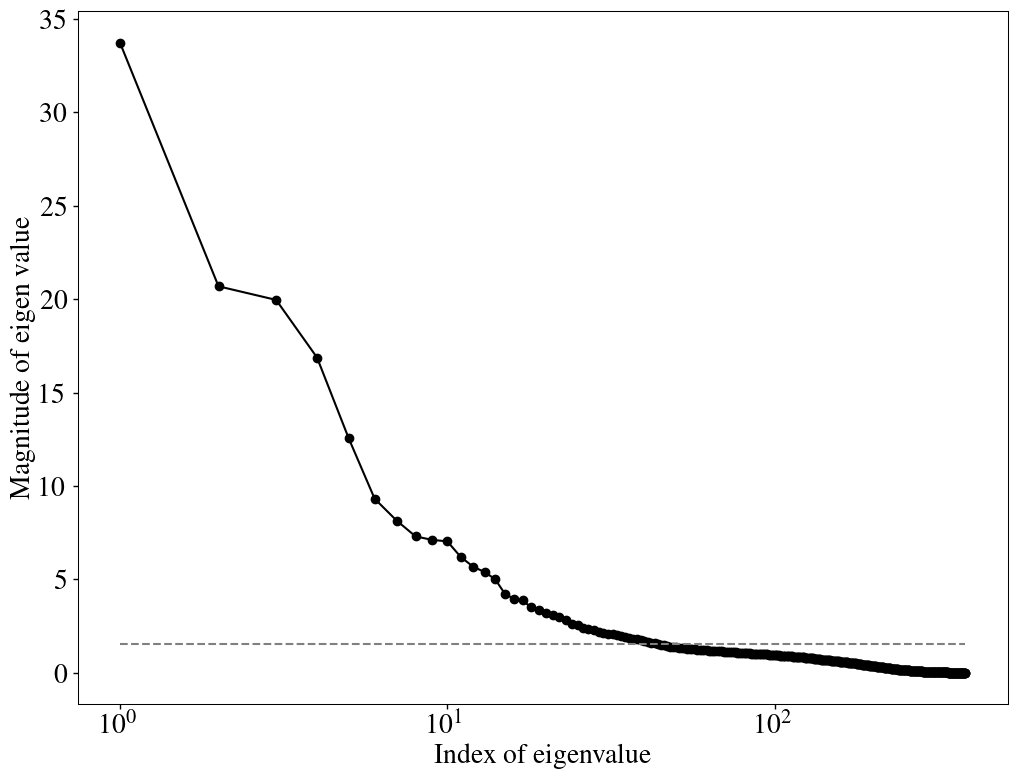

<Figure size 1200x900 with 0 Axes>

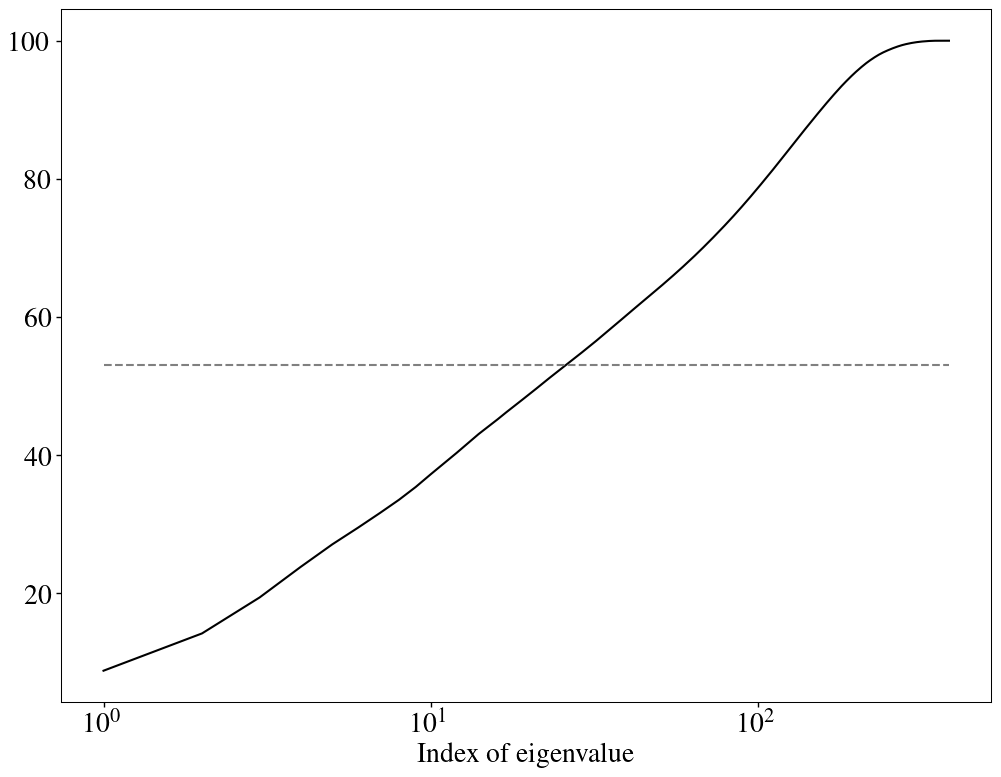

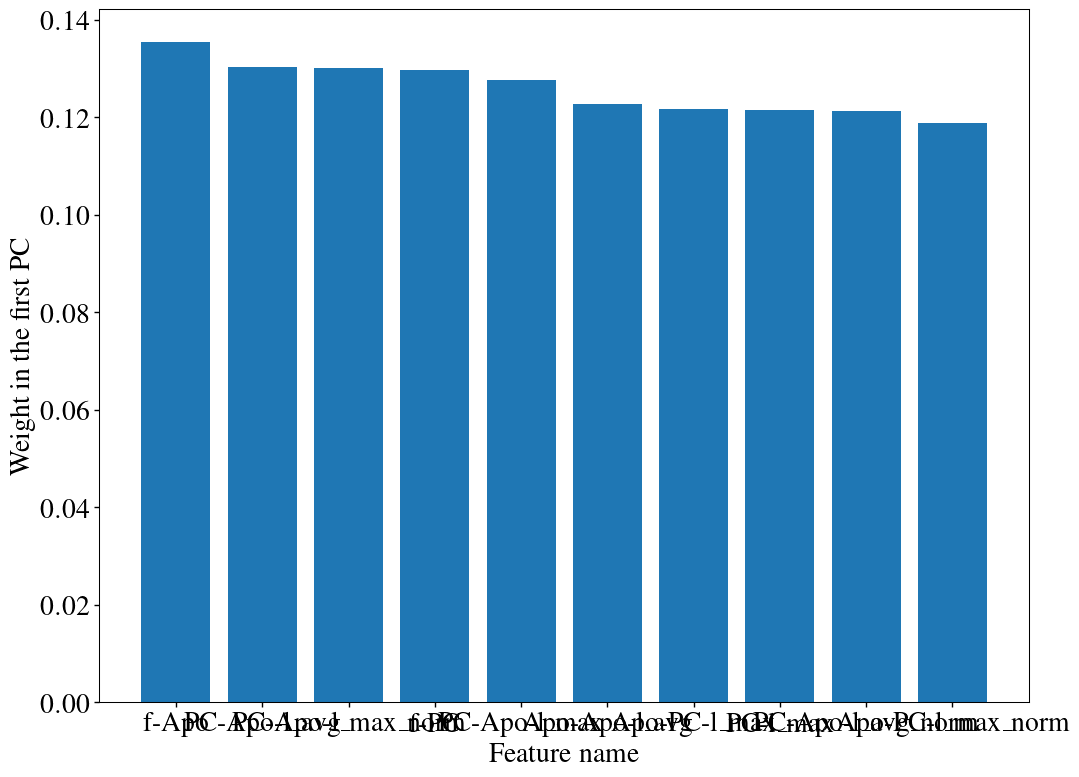

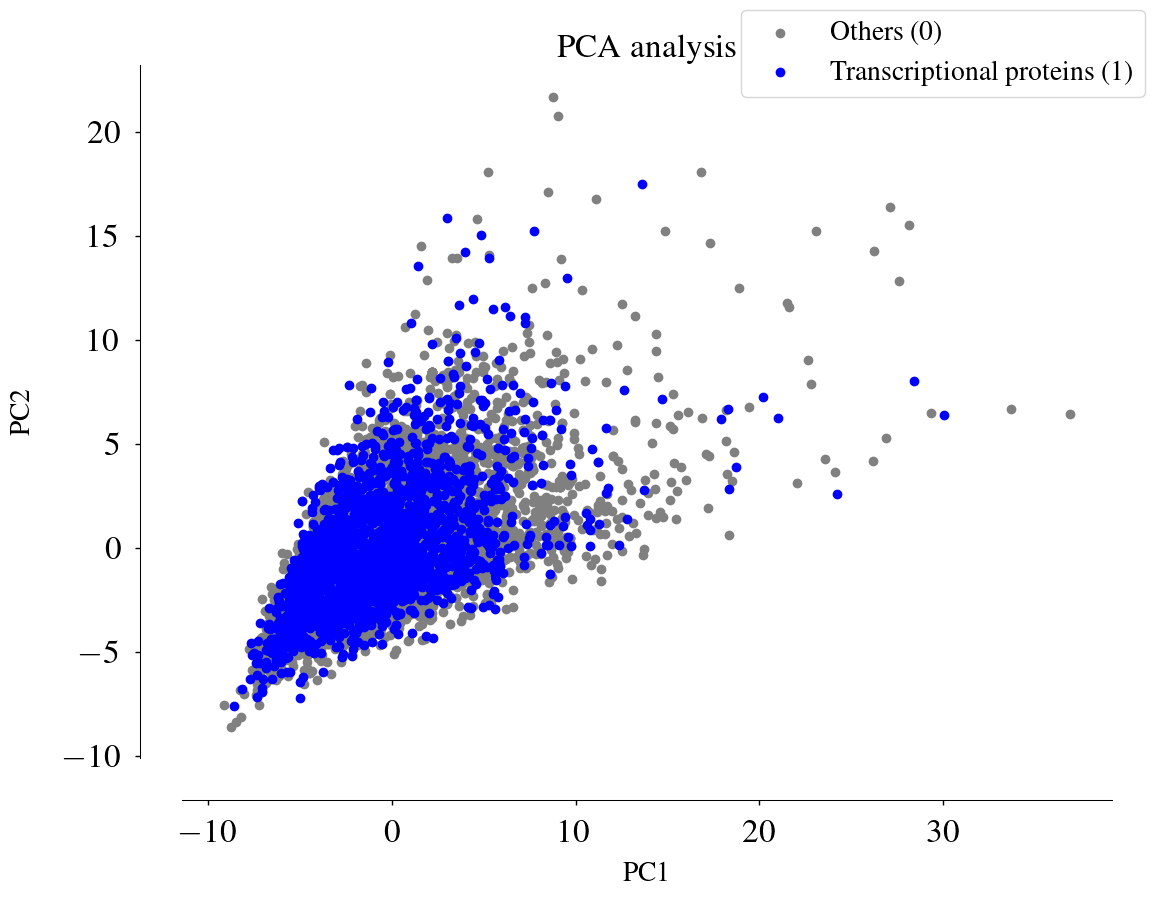

In [18]:
input_file = '../data/featurized_data_matrix/featurization_2019/normData.csv'
write_path = '../data/featurized_data_matrix/featurization_2019/normData_PCA'
filename = 'normData'

data_matrix = pd.read_csv(input_file)
# Drop the first column as it just contains the sequence names
data_matrix.drop(data_matrix.columns[0], axis=1, inplace=True)
# Convert the labels of 1 (transcription factors) and 2 (coactivators) into just 1
data_matrix.iloc[:,-1] = data_matrix.iloc[:,-1] > 0

# Dimensionality reduction
(eig_vals, eig_vecs, pc_scores)= ct.PCA_analysis(data_matrix.iloc[:, :-1].values,
                                                 centered=True,
                                                 clean_matrix=False,
                                                 clean_threshold=2.0,
                                                 write_PC_scores=True,
                                                 write_path=write_path)

# Plot eigenvalue spectrum and percent variance explained
plot_eigenvalue_plot(data_matrix, write_path=write_path, filename=filename)

# Plot the top few features in the first principal component
plot_top_n_features(eig_vecs=eig_vecs, data_matrix=data_matrix)

# Plot2D projection of data with labels
colors = ['grey','blue']
label_legends = ['Others (0)', 'Transcriptional proteins (1)']
ax = ct.plot_PCA(pc_scores,
                 T=data_matrix.iloc[:,-1],
                 pc_int1=0,
                 pc_int2=1,
                 colors=colors,
                 labels=label_legends,
                 file_save=1,
                 write_path=write_path+'/')

Directory ../data/featurized_data_matrix/featurization_2019/normData_PCA/clustering_results/Cluster_Purity_ already exists
[518. 725. 627. 279.  29. 537. 669. 437. 686. 166. 360.  71. 505.   7.
  63. 148.  11.  93. 196.  48.]
Directory ../data/featurized_data_matrix/featurization_2019/normData_PCA already exists


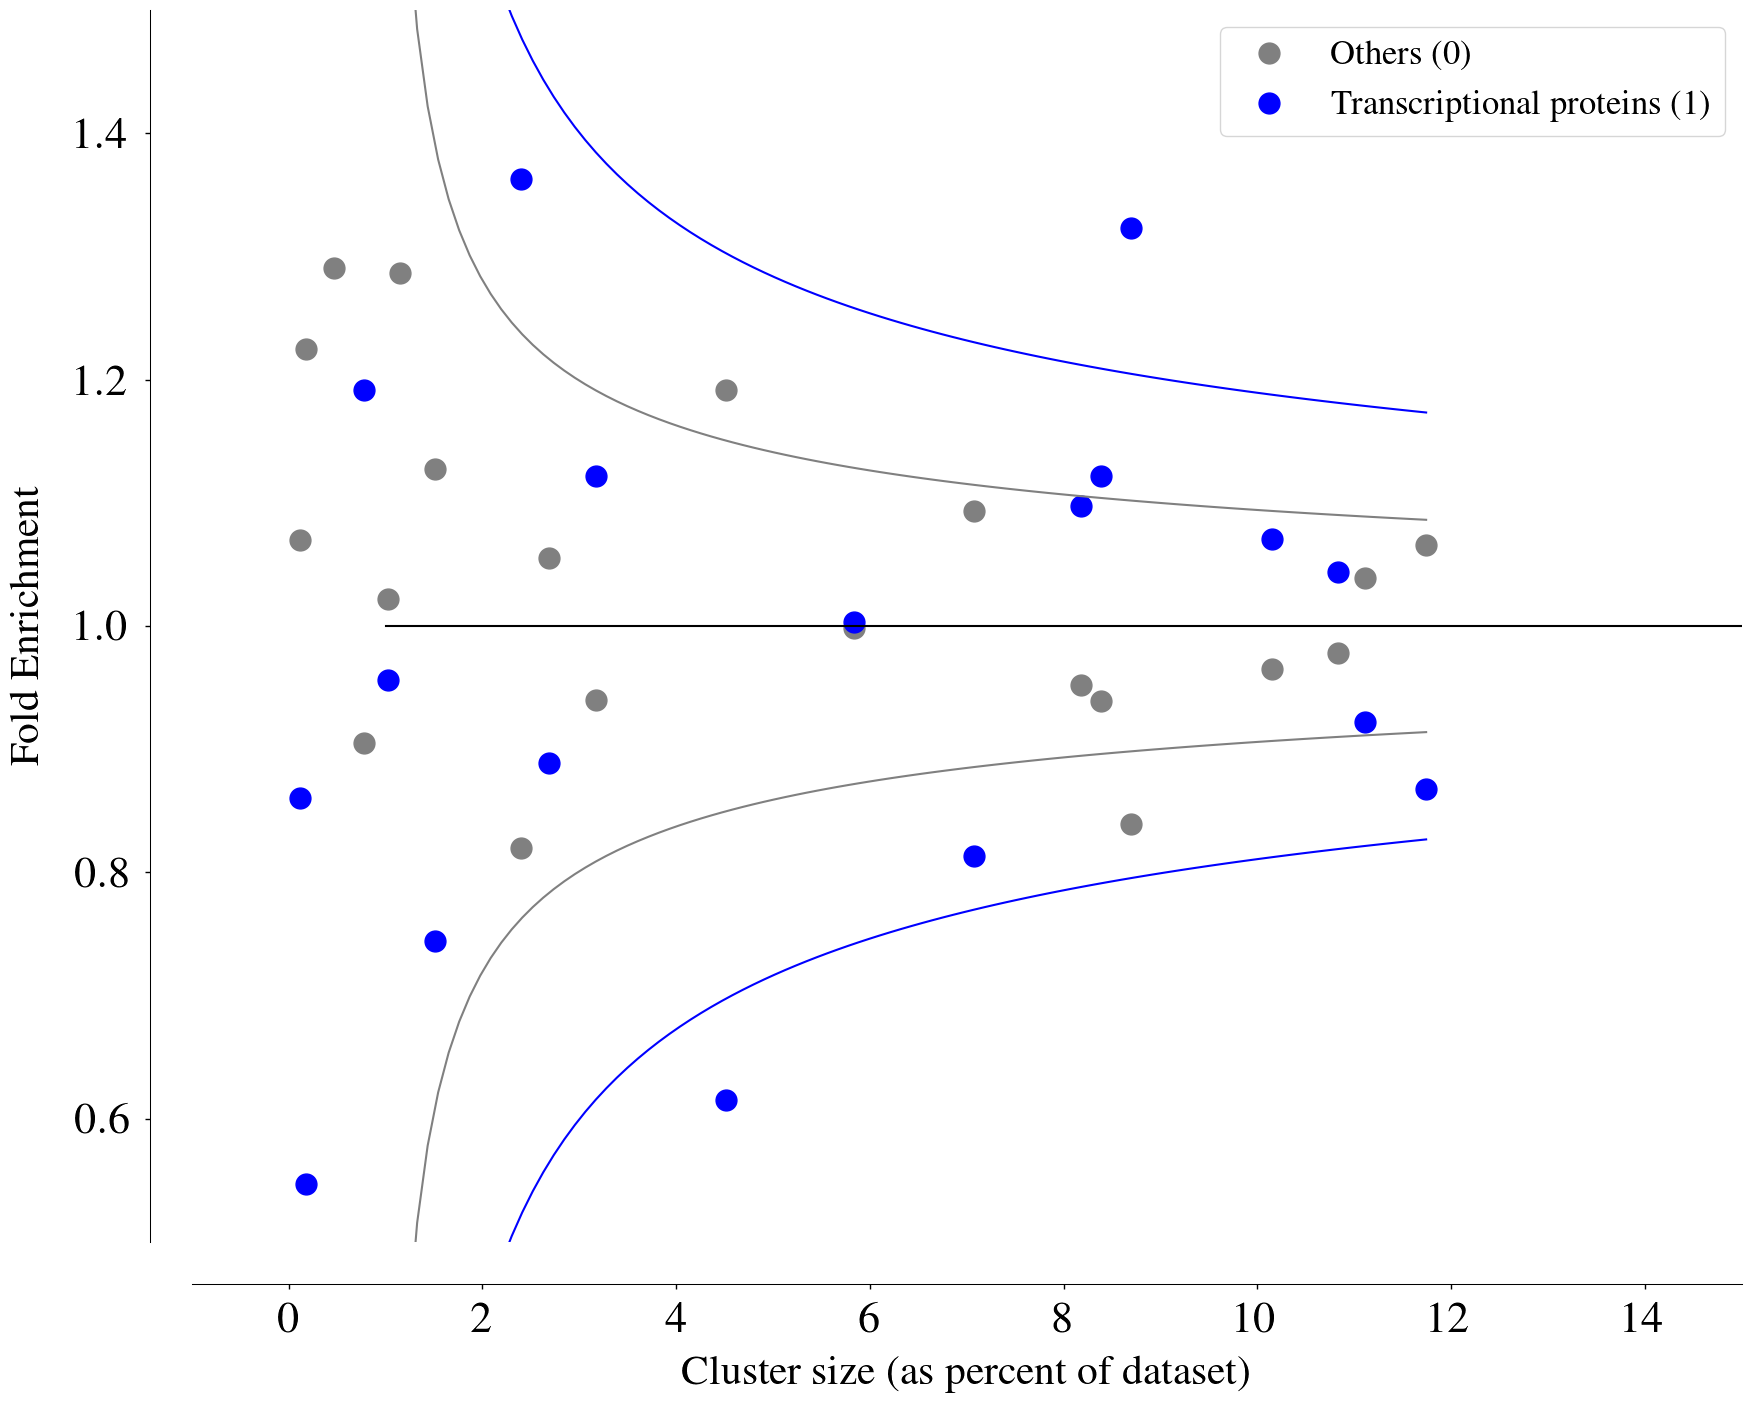

In [20]:
# Cluster the data and analyze cluster compositions

n_pcs = len(data_matrix.columns[:-1])
n_clusters = 20

labels = data_matrix.iloc[:,-1]

graph_labels = label_legends

xlim=(-1,15)
ylim=(0.5,1.5)

# Clustering after dim reduction using PCA:
clust_labels_PCA = dgen.cluster_reduced_matrix(pc_scores, labels, n_pcs, n_clusters, write_path, 1, 1)
# dgen.generate_purity_plots(write_file_path, graph_labels, flag_save_files, 1, n_pcs, n_clusters)
dgen.plot_enrichment_vs_cluster_size(write_path, '/' + filename + '_cluster_enrichment', 
                                     data_matrix, 
                                     labels, 
                                     graph_labels, 
                                     colors, xlim, ylim, 
                                     1, 1, n_pcs, n_clusters)

## Analysis of the dataset with 470 reduced features

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


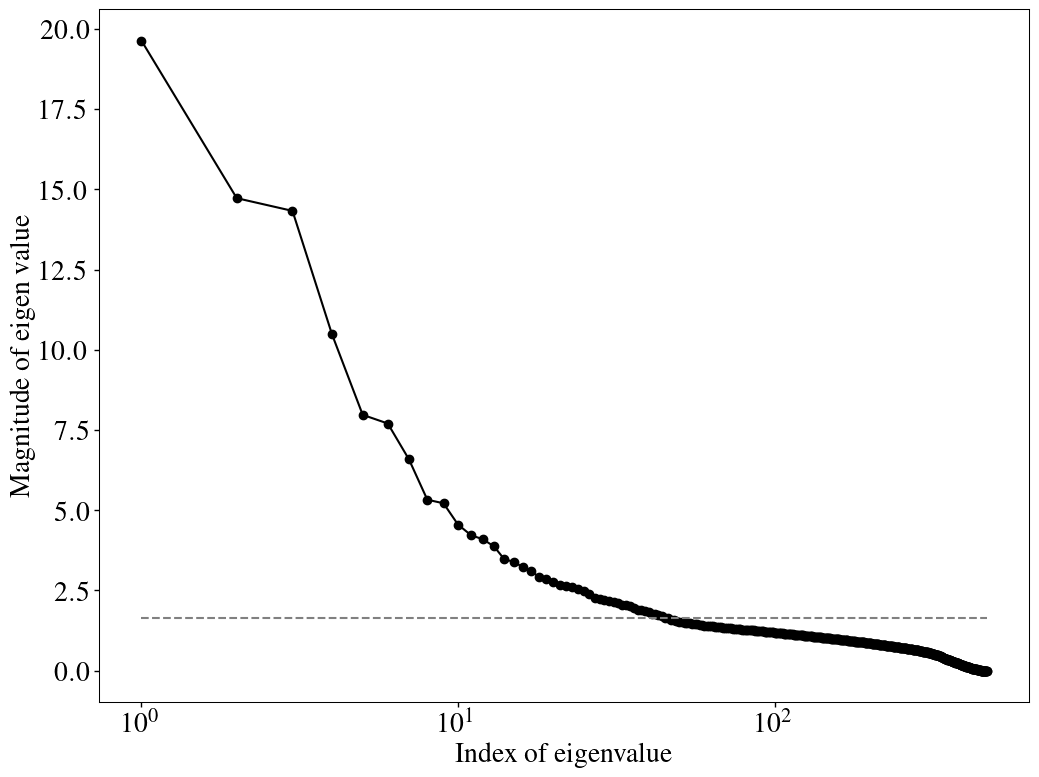

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 1200x900 with 0 Axes>

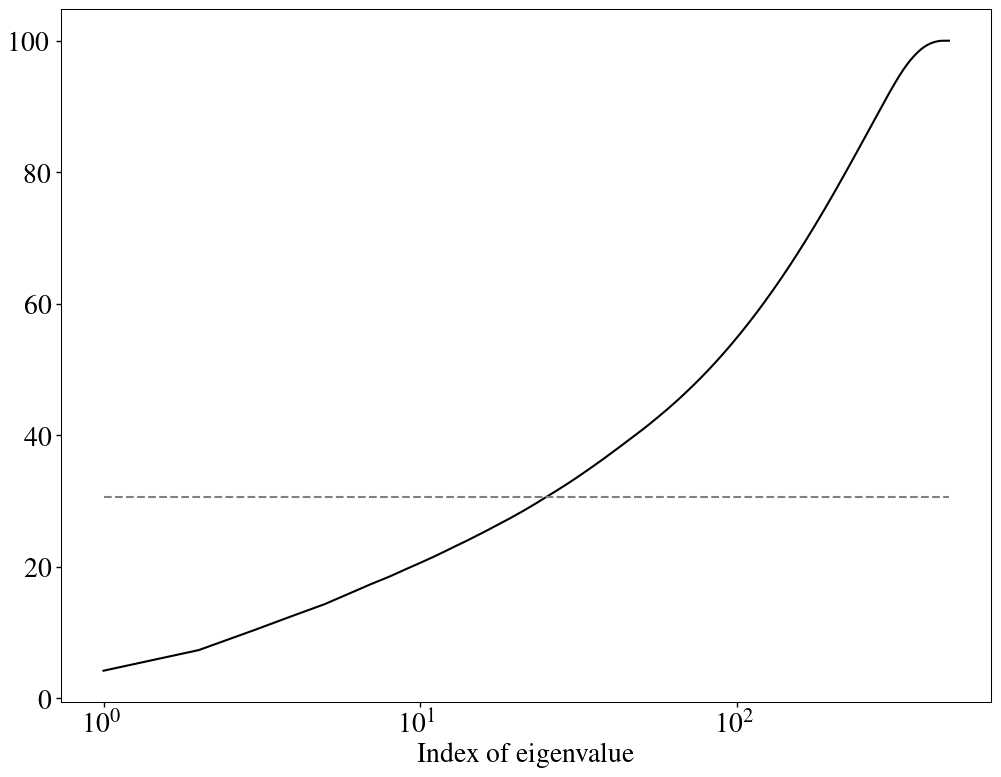

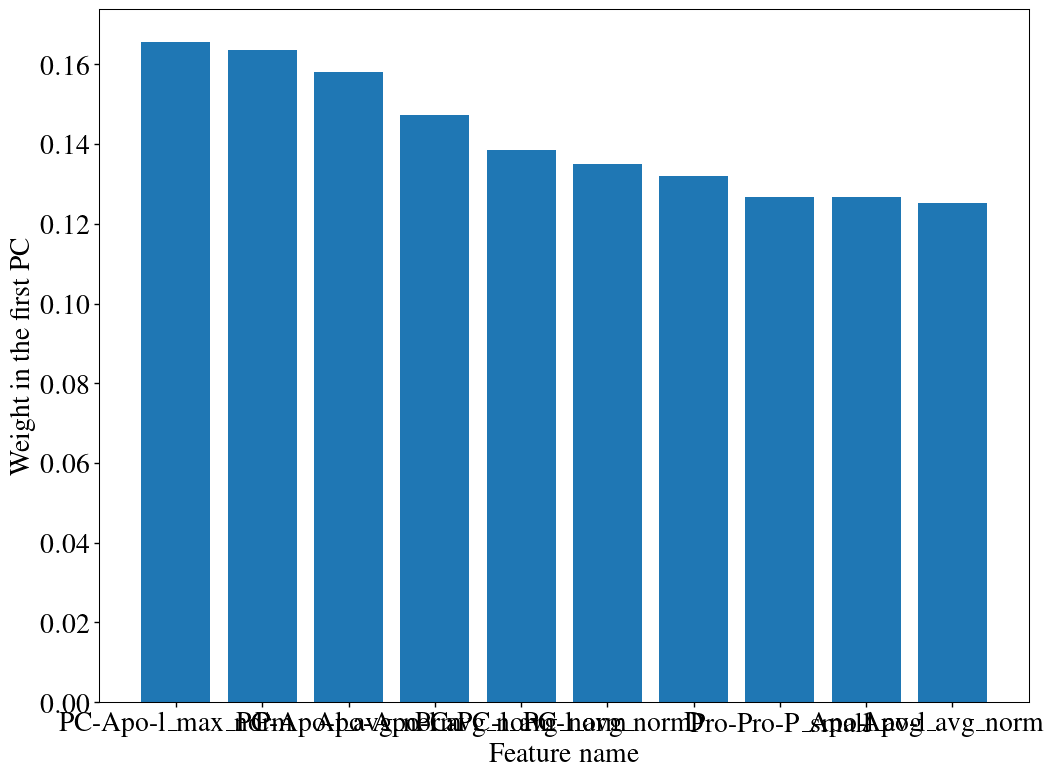

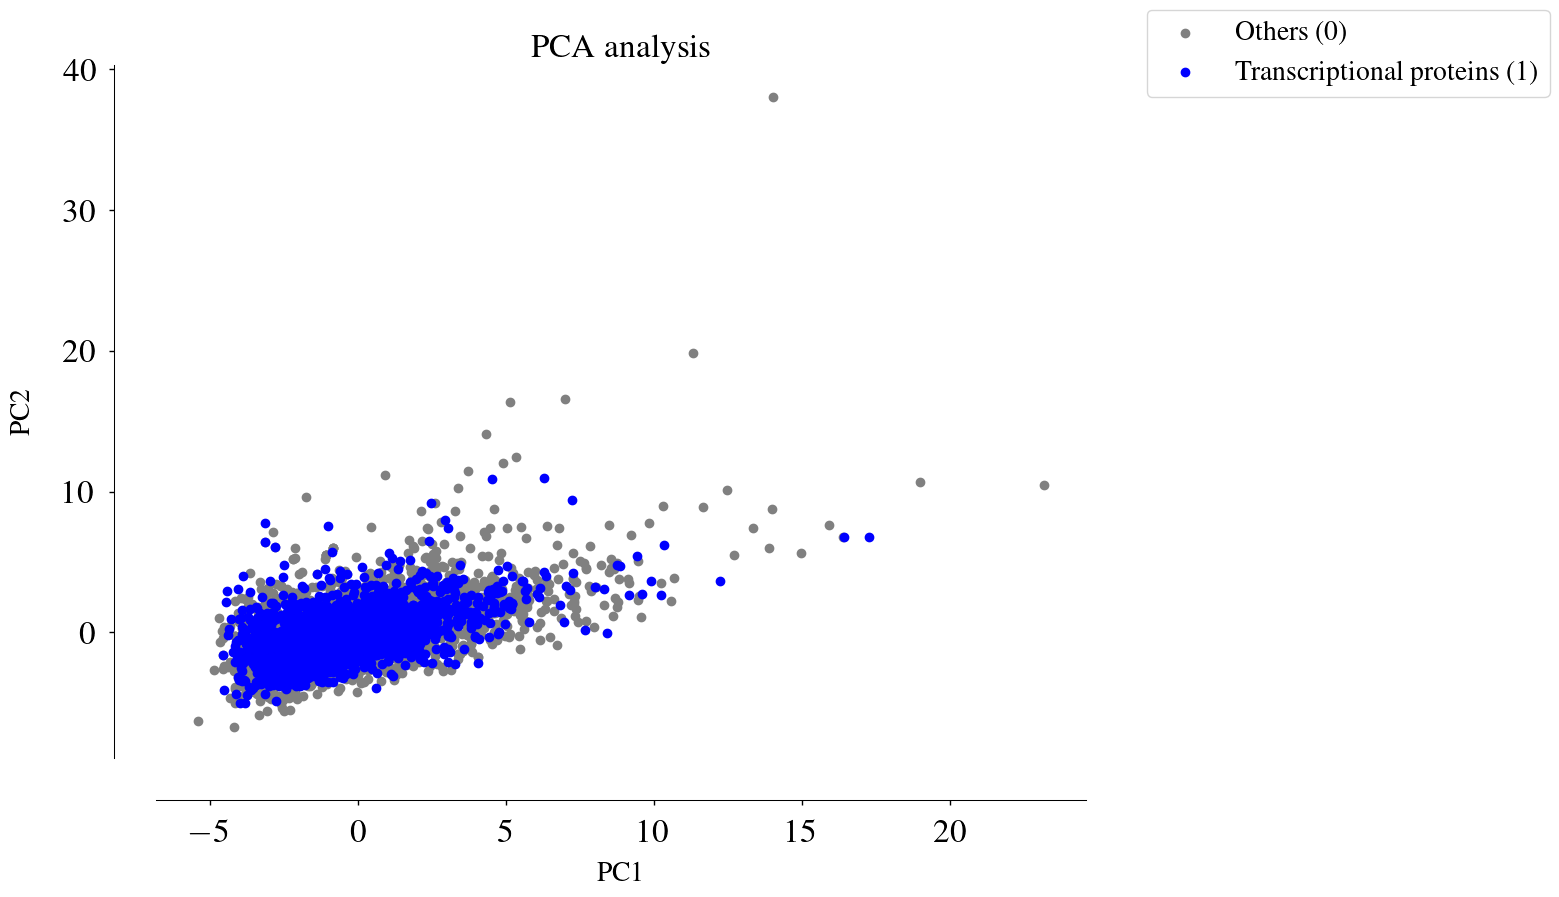

In [21]:
input_file = '../data/featurized_data_matrix/featurization_2019/preprocessed470.csv'
write_path = '../data/featurized_data_matrix/featurization_2019/preprocessed470'
filename = 'preprocessed470'

data_matrix = pd.read_csv(input_file)
# Drop the first column as it just contains the sequence names
data_matrix.drop(data_matrix.columns[0], axis=1, inplace=True)
# Convert the labels of 1 (transcription factors) and 2 (coactivators) into just 1
data_matrix.iloc[:,-1] = data_matrix.iloc[:,-1] > 0

# Dimensionality reduction
(eig_vals, eig_vecs, pc_scores)= ct.PCA_analysis(data_matrix.iloc[:, :-1].values,
                                                 centered=True,
                                                 clean_matrix=False,
                                                 clean_threshold=2.0,
                                                 write_PC_scores=True,
                                                 write_path=write_path)

# Plot eigenvalue spectrum and percent variance explained
plot_eigenvalue_plot(data_matrix, write_path=write_path, filename=filename)

# Plot the top few features in the first principal component
plot_top_n_features(eig_vecs=eig_vecs, data_matrix=data_matrix)

# Plot2D projection of data with labels
colors = ['grey','blue']
label_legends = ['Others (0)', 'Transcriptional proteins (1)']
ax = ct.plot_PCA(pc_scores,
                 T=data_matrix.iloc[:,-1],
                 pc_int1=0,
                 pc_int2=1,
                 colors=colors,
                 labels=label_legends,
                 file_save=1,
                 write_path=write_path+'/')

Directory ../data/featurized_data_matrix/featurization_2019/preprocessed470/clustering_results/Cluster_Purity_ already exists
[687. 875. 302.  54. 363. 621. 314.  44.  67.  11. 559. 735. 677. 113.
 455. 133.  49.   7. 108.   1.]
Directory ../data/featurized_data_matrix/featurization_2019/preprocessed470 already exists


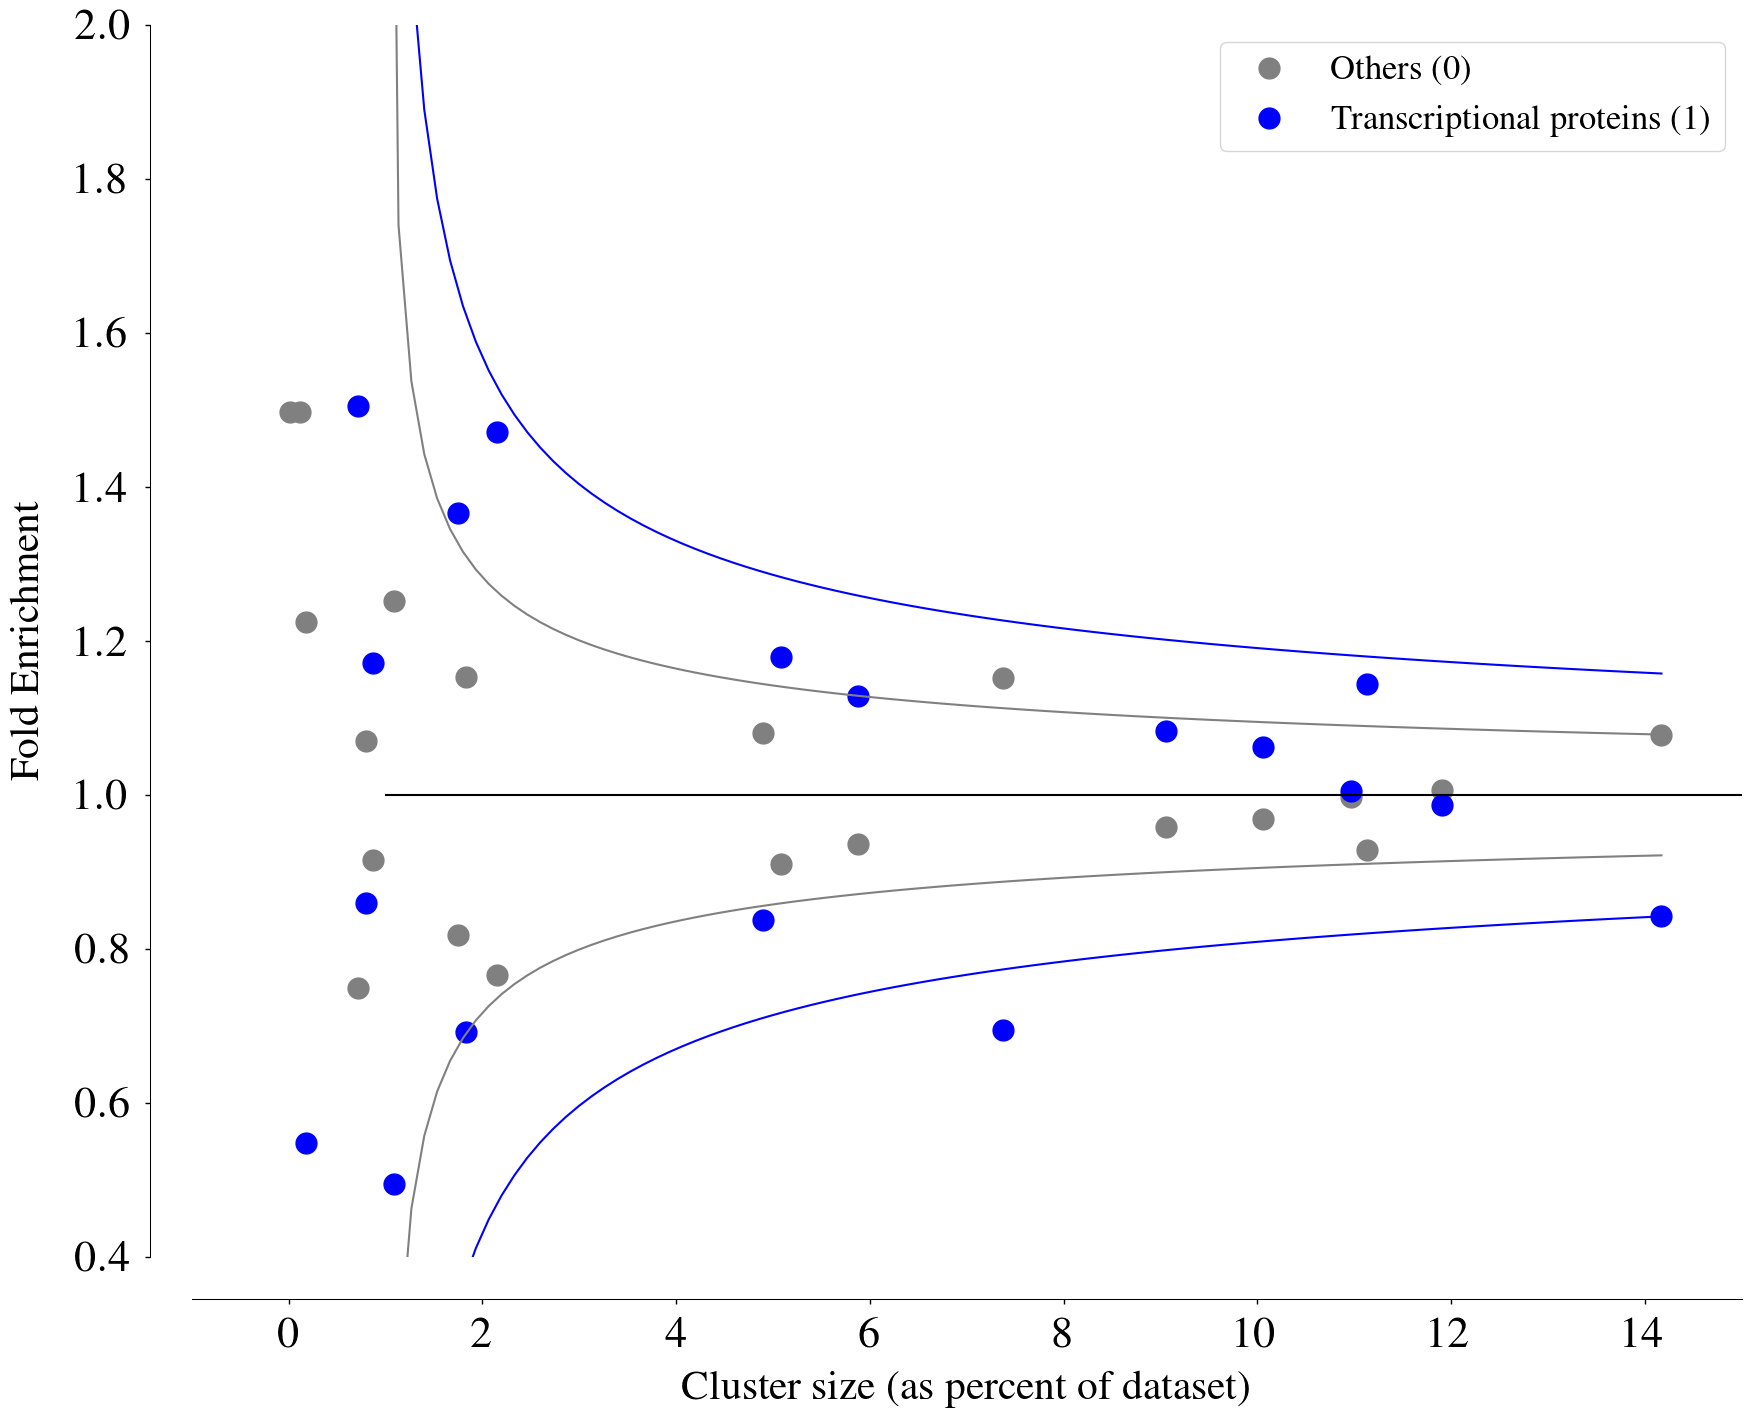

In [23]:
# Cluster the data and analyze cluster compositions

n_pcs = len(data_matrix.columns[:-1])
n_clusters = 20

labels = data_matrix.iloc[:,-1]

graph_labels = label_legends

xlim=(-1,15)
ylim=(0.4,2.0)

# Clustering after dim reduction using PCA:
clust_labels_PCA = dgen.cluster_reduced_matrix(pc_scores, labels, n_pcs, n_clusters, write_path, 1, 1)
# dgen.generate_purity_plots(write_file_path, graph_labels, flag_save_files, 1, n_pcs, n_clusters)
dgen.plot_enrichment_vs_cluster_size(write_path, '/' + filename + '_cluster_enrichment', 
                                     data_matrix, 
                                     labels, 
                                     graph_labels, 
                                     colors, xlim, ylim, 
                                     1, 1, n_pcs, n_clusters)

## Analysis of dataset with 178 reduced features

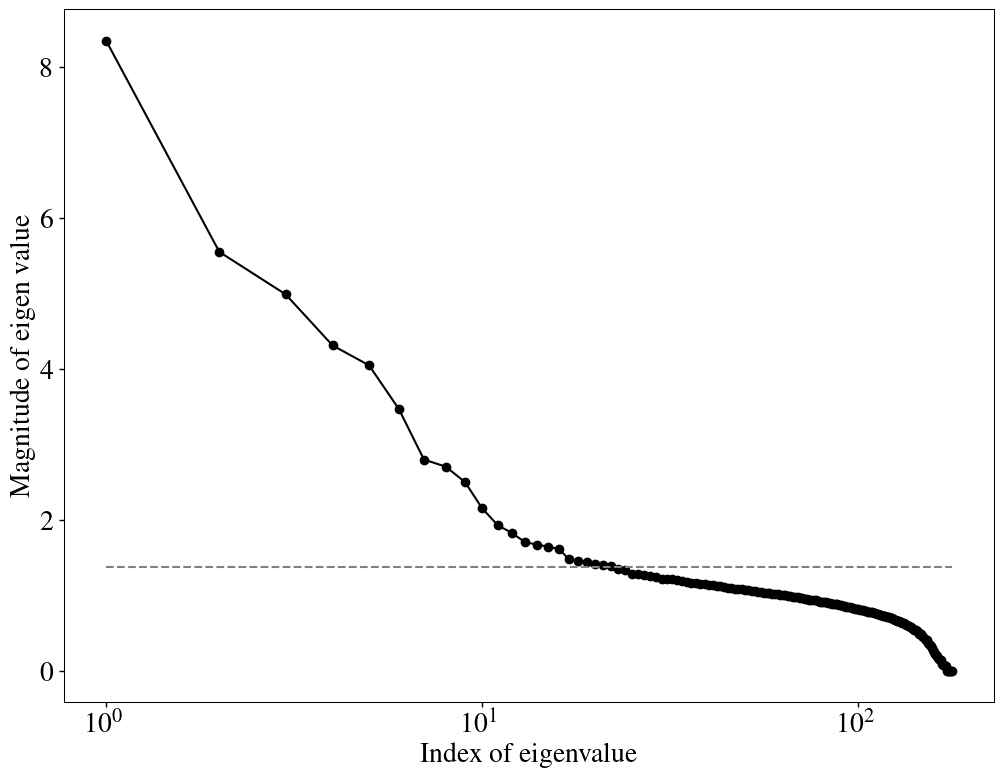

<Figure size 1200x900 with 0 Axes>

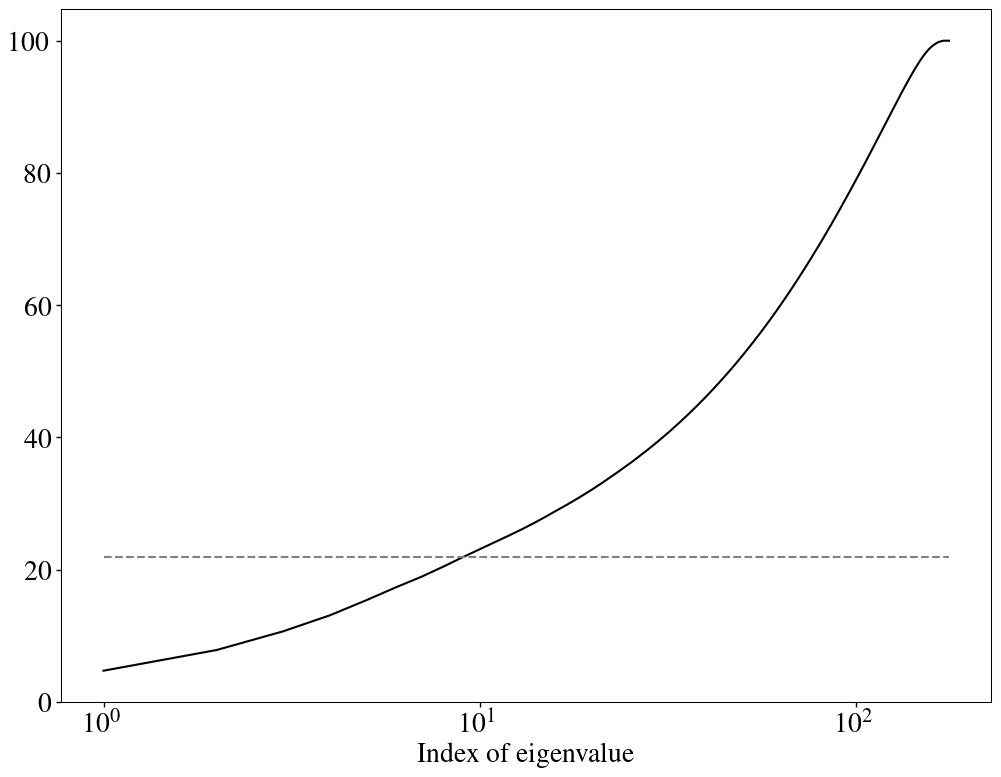

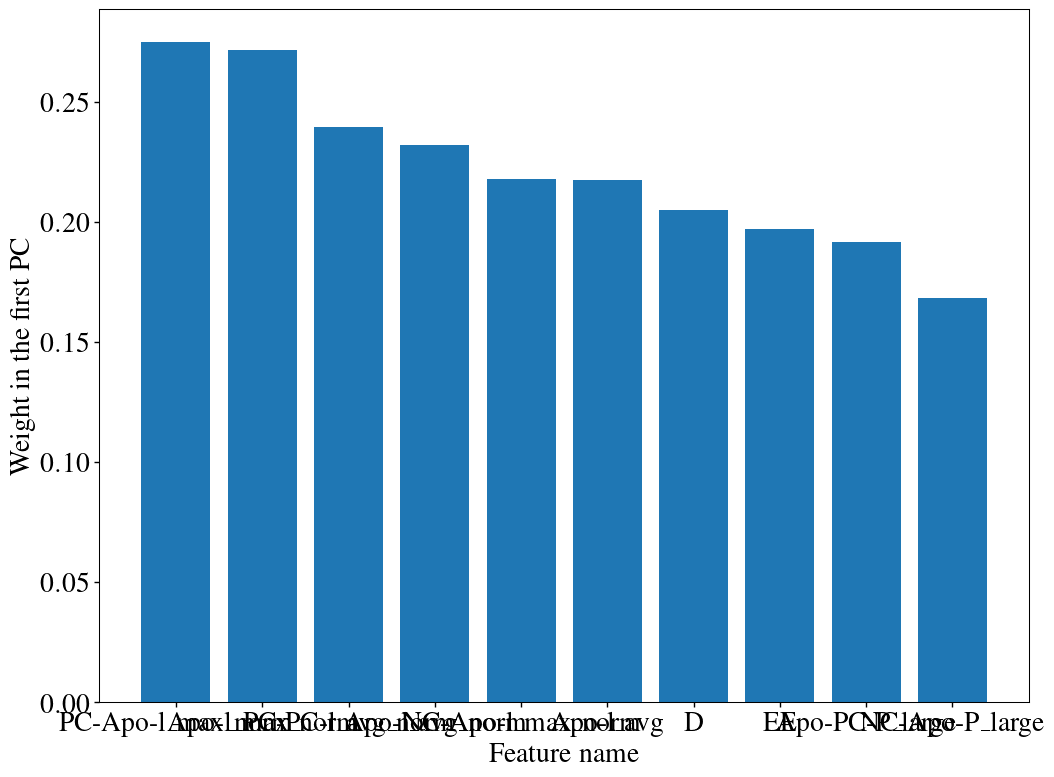

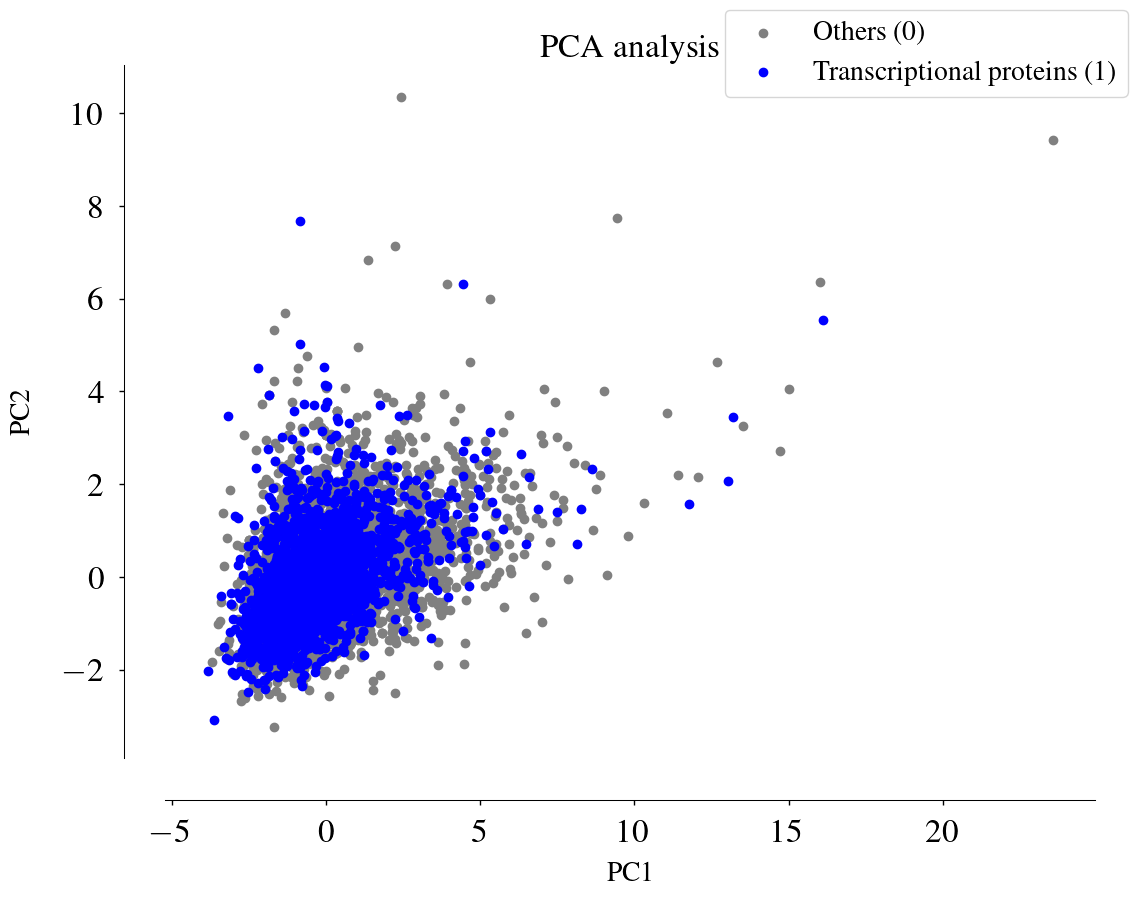

In [22]:
input_file = '../data/featurized_data_matrix/featurization_2019/preprocessed178.csv'
write_path = '../data/featurized_data_matrix/featurization_2019/preprocessed178'
filename = 'preprocessed178'

data_matrix = pd.read_csv(input_file)
# Drop the first column as it just contains the sequence names
data_matrix.drop(data_matrix.columns[0], axis=1, inplace=True)
# Convert the labels of 1 (transcription factors) and 2 (coactivators) into just 1
data_matrix.iloc[:,-1] = data_matrix.iloc[:,-1] > 0

# Dimensionality reduction
(eig_vals, eig_vecs, pc_scores)= ct.PCA_analysis(data_matrix.iloc[:, :-1].values,
                                                 centered=True,
                                                 clean_matrix=False,
                                                 clean_threshold=2.0,
                                                 write_PC_scores=True,
                                                 write_path=write_path)

# Plot eigenvalue spectrum and percent variance explained
plot_eigenvalue_plot(data_matrix, write_path=write_path, filename=filename)

# Plot the top few features in the first principal component
plot_top_n_features(eig_vecs=eig_vecs, data_matrix=data_matrix)

# Plot2D projection of data with labels
colors = ['grey','blue']
label_legends = ['Others (0)', 'Transcriptional proteins (1)']
ax = ct.plot_PCA(pc_scores,
                 T=data_matrix.iloc[:,-1],
                 pc_int1=0,
                 pc_int2=1,
                 colors=colors,
                 labels=label_legends,
                 file_save=1,
                 write_path=write_path+'/')

Directory ../data/featurized_data_matrix/featurization_2019/preprocessed178/clustering_results/Cluster_Purity_ already exists
[110. 248. 542.  19. 921. 174. 821. 196. 173. 295. 296.  39. 524. 165.
 164.  88. 265. 487. 540. 108.]
Directory ../data/featurized_data_matrix/featurization_2019/preprocessed178 already exists


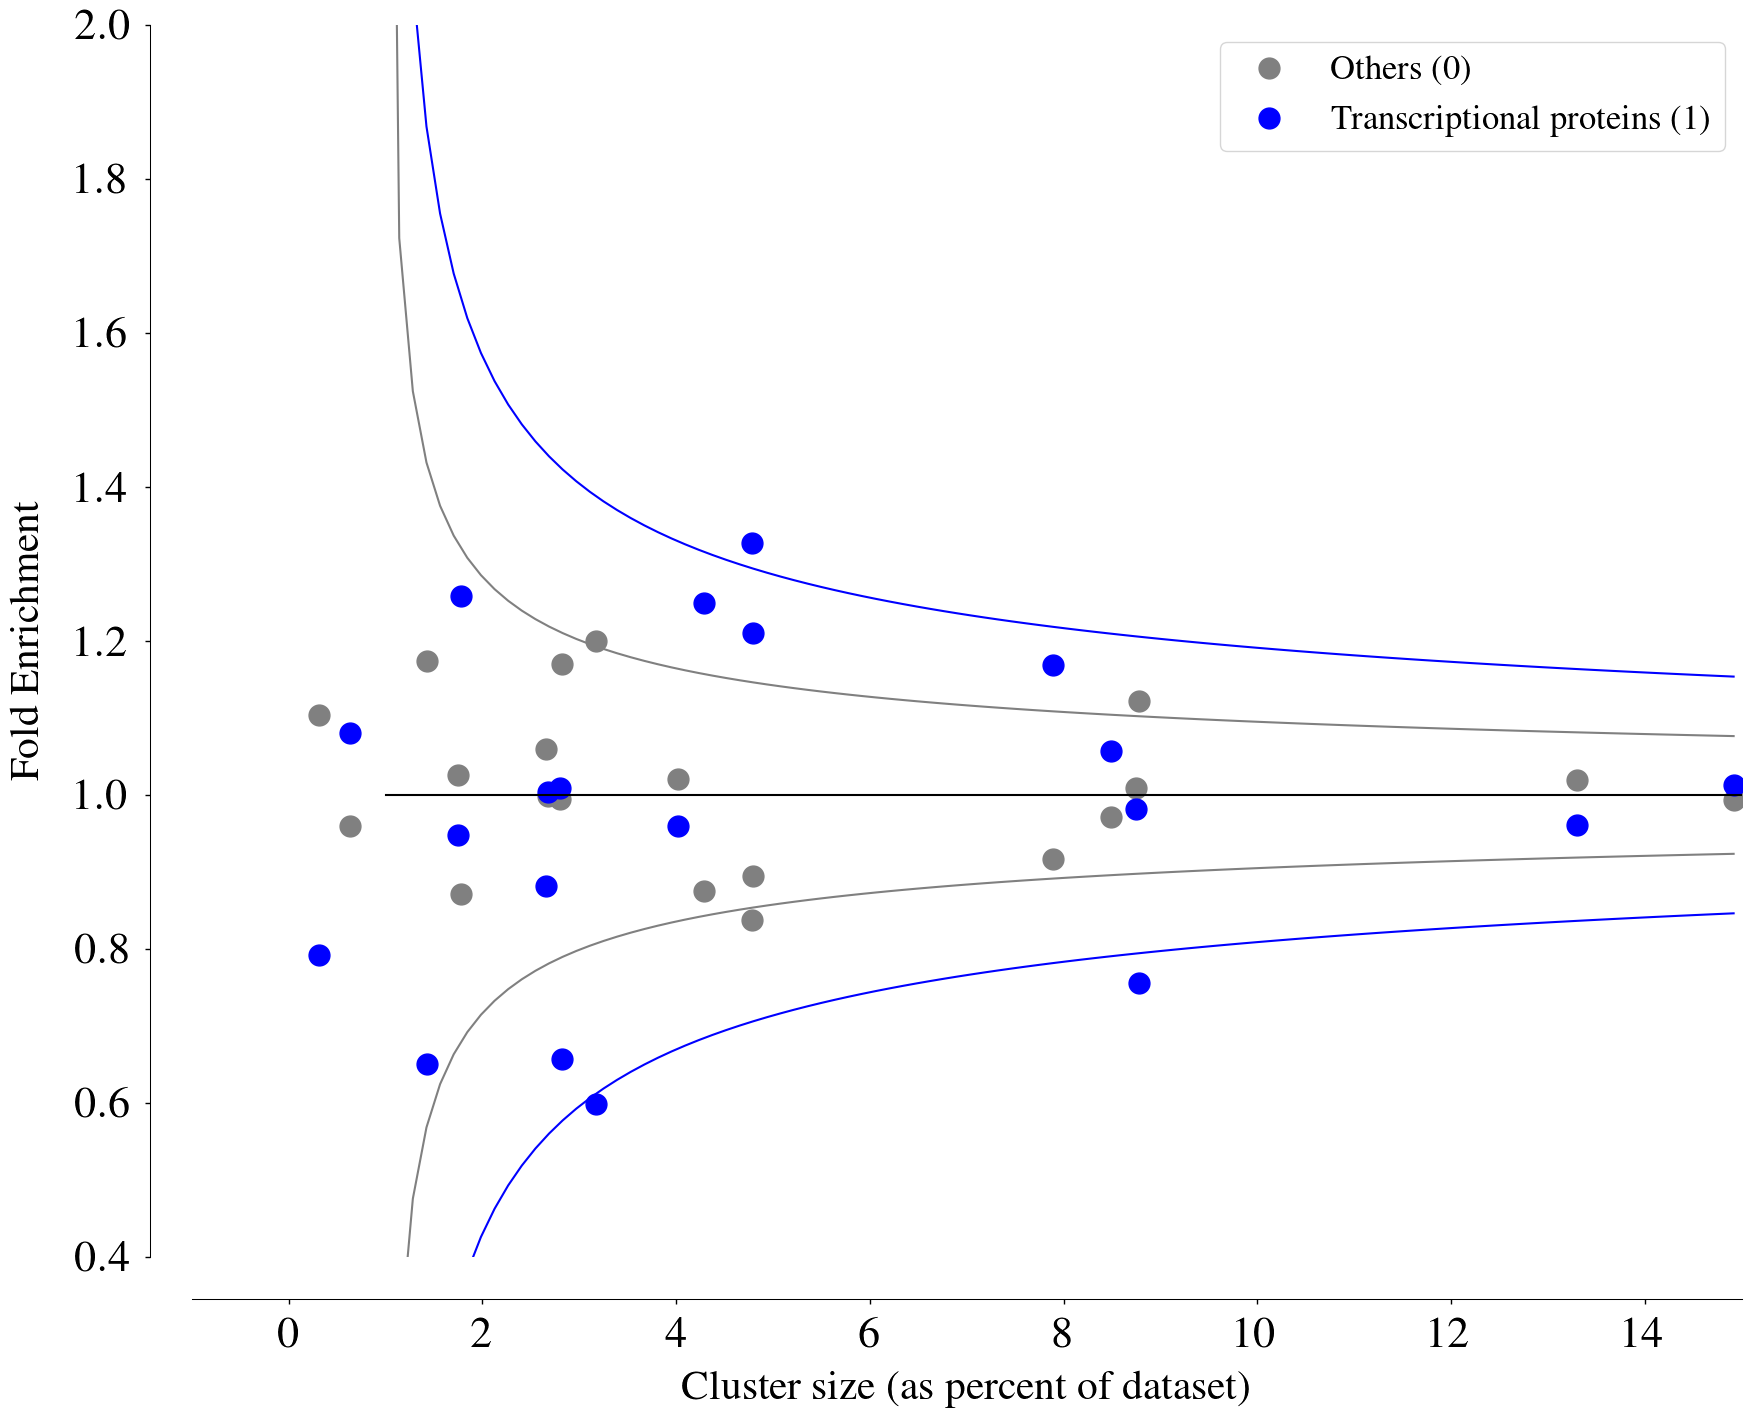

In [23]:
# Cluster the data and analyze cluster compositions

n_pcs = len(data_matrix.columns[:-1])
n_clusters = 20

labels = data_matrix.iloc[:,-1]

graph_labels = label_legends

xlim=(-1,15)
ylim=(0.4,2.0)

# Clustering after dim reduction using PCA:
clust_labels_PCA = dgen.cluster_reduced_matrix(pc_scores, labels, n_pcs, n_clusters, write_path, 1, 1)
# dgen.generate_purity_plots(write_file_path, graph_labels, flag_save_files, 1, n_pcs, n_clusters)
dgen.plot_enrichment_vs_cluster_size(write_path, '/' + filename + '_cluster_enrichment', 
                                     data_matrix, 
                                     labels, 
                                     graph_labels, 
                                     colors, xlim, ylim, 
                                     1, 1, n_pcs, n_clusters)

## Analyzing data matrix based on embeddings generated by BERT 

In [35]:
input_file = '../data/filtered_sequence_data/filtered_sequences_linker_45_stitch_12_filtered_embeddings.pkl'
data_matrix_file = '../data/featurized_data_matrix/featurization_BERT_embeddings/BERT_data_matrix.csv'

# convert pickle file to data matrix file
pkl_to_data_matrix(input_file=input_file, output_file=data_matrix_file)

write_path = '../data/featurized_data_matrix/featurization_BERT_embeddings/BERT_embeddings'
filename = 'BERT_embeddings'

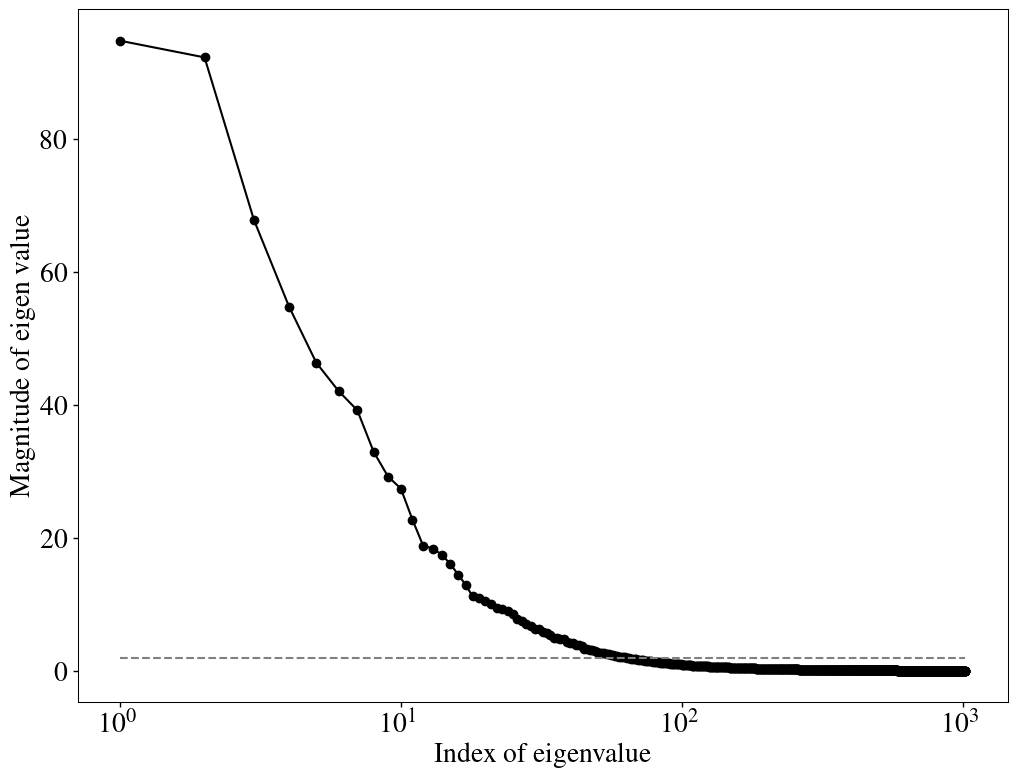

<Figure size 1200x900 with 0 Axes>

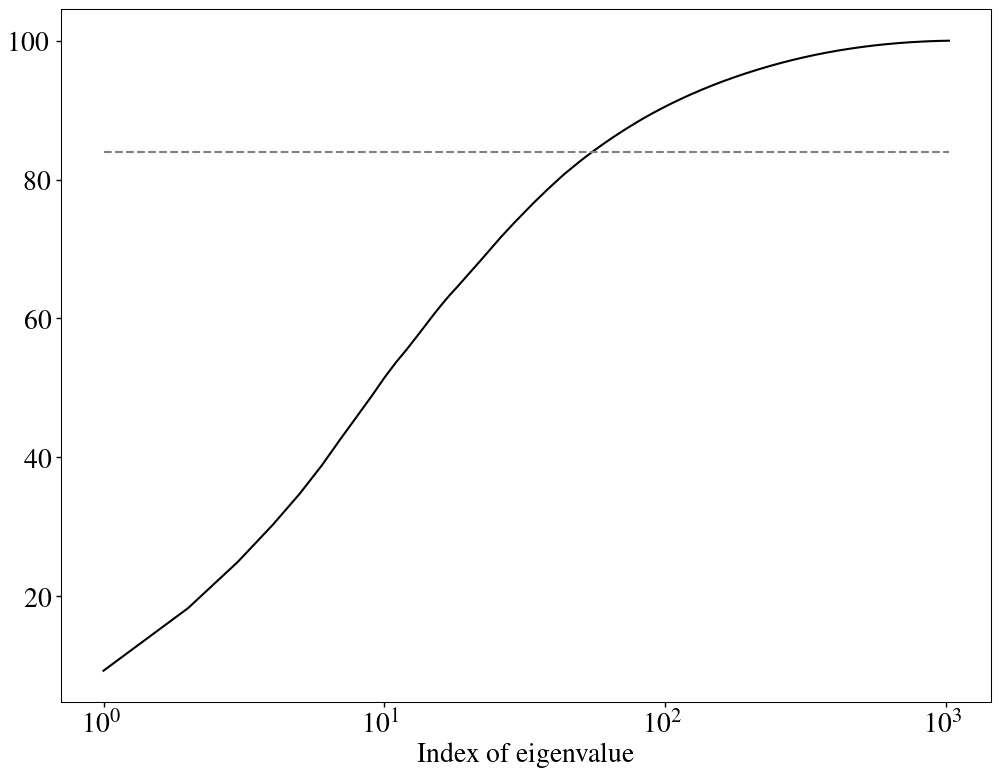

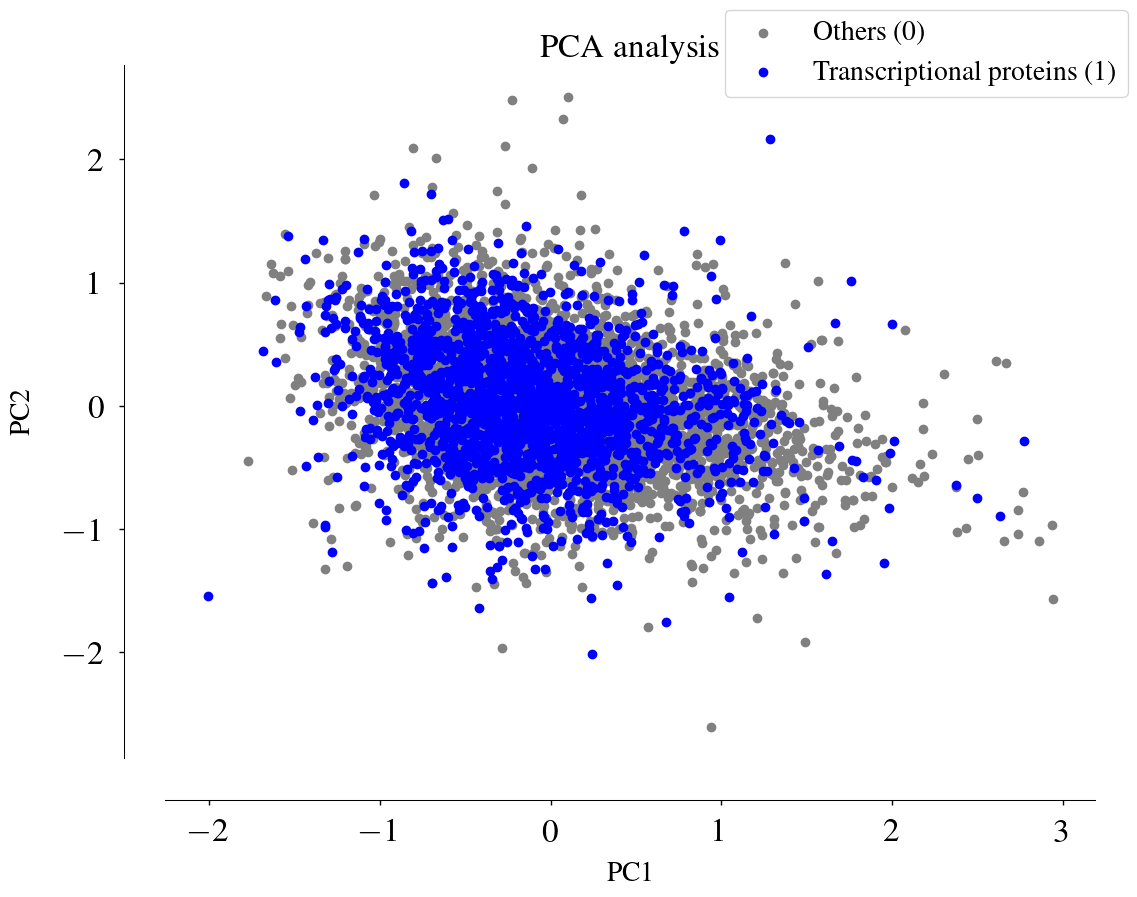

In [37]:
data_matrix_file_with_labels = '../data/featurized_data_matrix/featurization_BERT_embeddings/BERT_data_matrix_with_labels.csv'

data_matrix = pd.read_csv(data_matrix_file_with_labels)
# Drop the first column as it just contains the sequence names
data_matrix.drop(data_matrix.columns[0], axis=1, inplace=True)
# Convert the labels of 1 (transcription factors) and 2 (coactivators) into just 1
data_matrix.iloc[:,-1] = data_matrix.iloc[:,-1] > 0

# Dimensionality reduction
(eig_vals, eig_vecs, pc_scores)= ct.PCA_analysis(data_matrix.iloc[:, :-1].values,
                                                 centered=True,
                                                 clean_matrix=False,
                                                 clean_threshold=2.0,
                                                 write_PC_scores=True,
                                                 write_path=write_path)

# Plot eigenvalue spectrum and percent variance explained
plot_eigenvalue_plot(data_matrix, write_path=write_path, filename=filename)

# Plot the top few features in the first principal component
# plot_top_n_features(eig_vecs=eig_vecs, data_matrix=data_matrix)

# Plot2D projection of data with labels
colors = ['grey','blue']
label_legends = ['Others (0)', 'Transcriptional proteins (1)']
ax = ct.plot_PCA(pc_scores,
                 T=data_matrix.iloc[:,-1],
                 pc_int1=0,
                 pc_int2=1,
                 colors=colors,
                 labels=label_legends,
                 file_save=1,
                 write_path=write_path+'/')

Directory ../data/featurized_data_matrix/featurization_BERT_embeddings/BERT_embeddings/clustering_results/Cluster_Purity_ Created 
[537. 232. 504. 191. 292. 504. 117. 180. 320. 667. 543. 527. 375.  45.
 479.  98. 316.  64.  39. 145.]
Directory ../data/featurized_data_matrix/featurization_BERT_embeddings/BERT_embeddings already exists


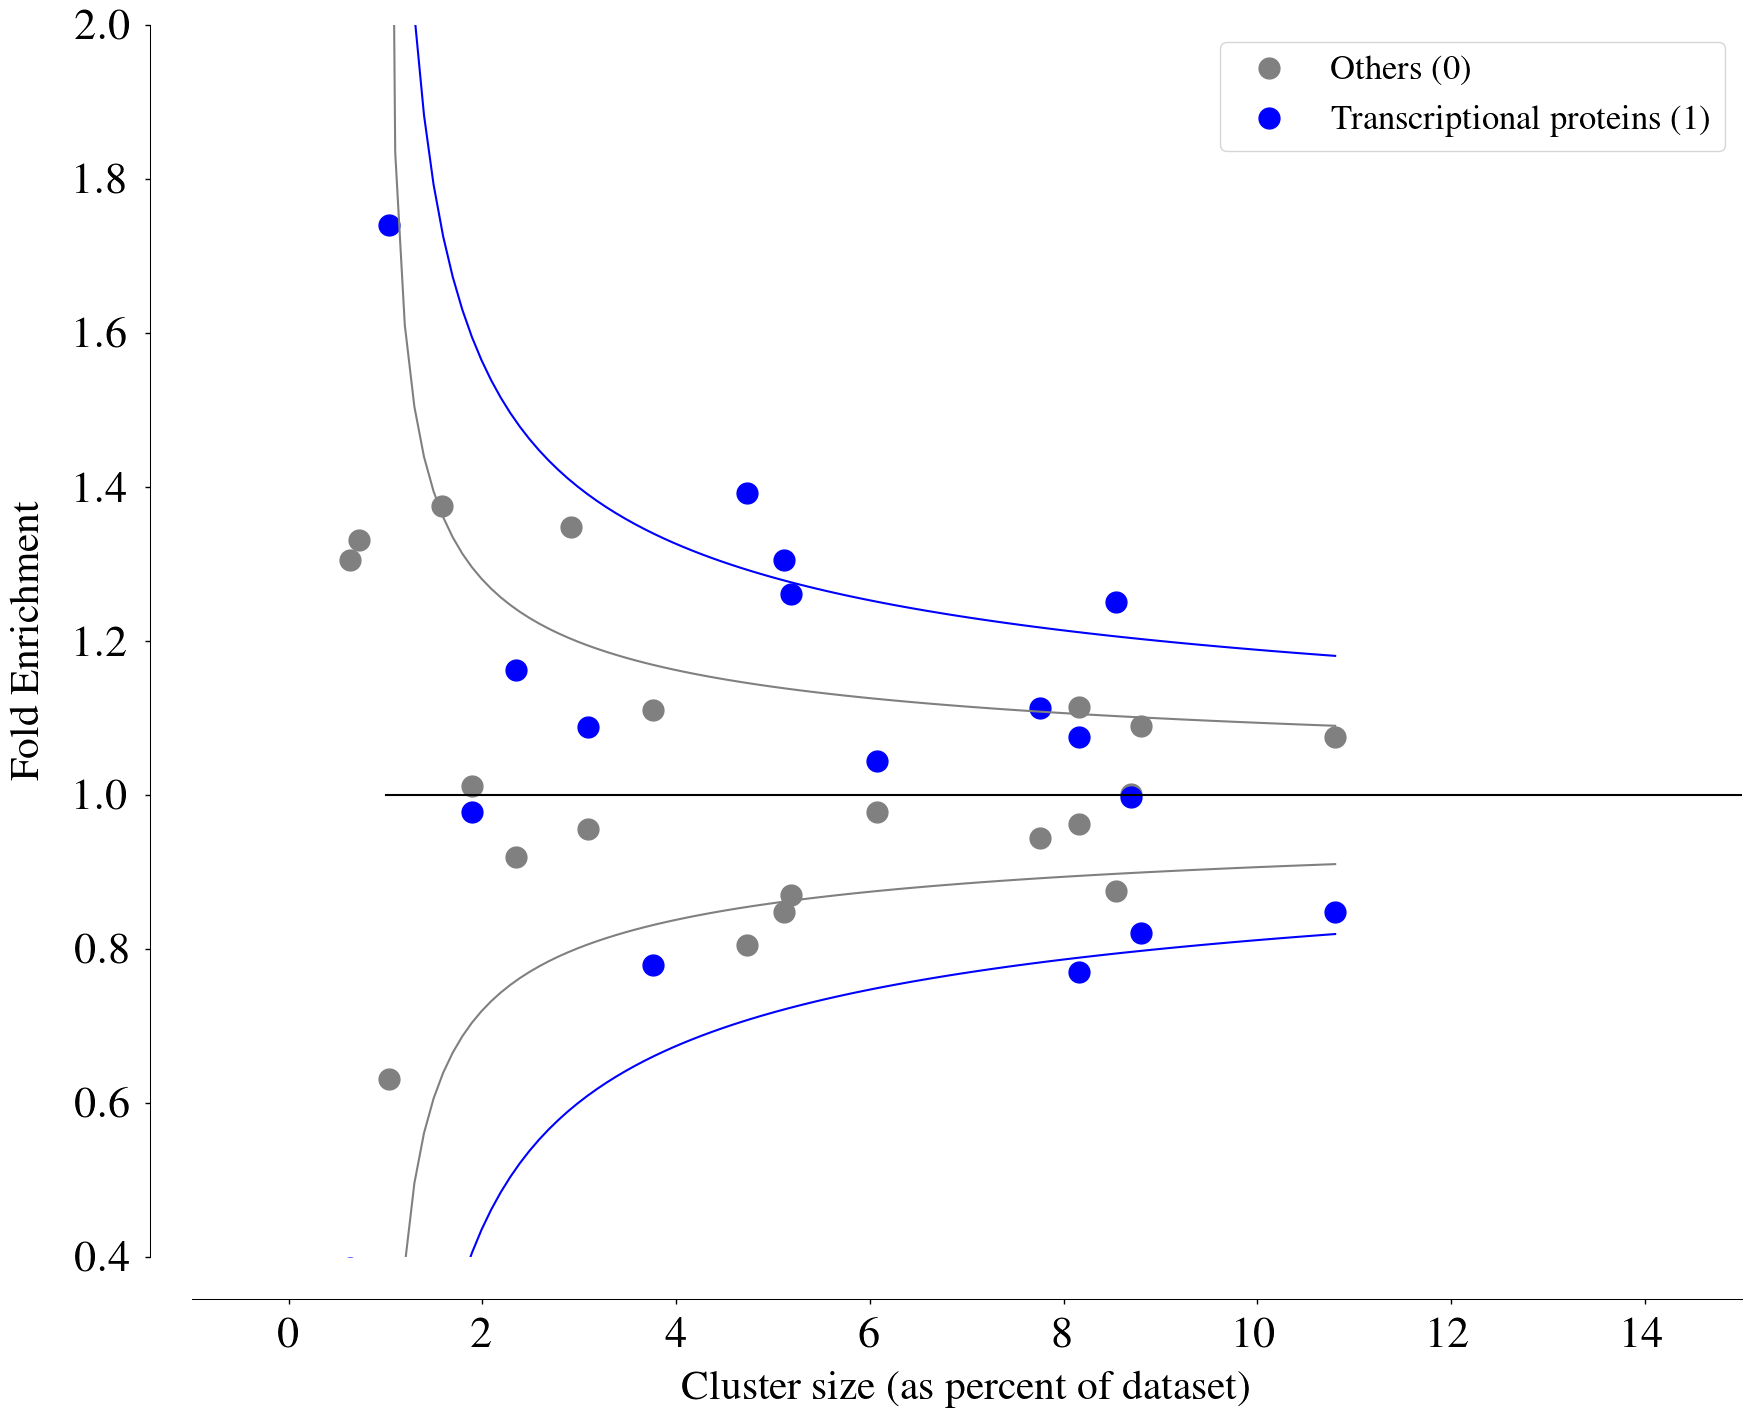

In [38]:
# Cluster the data and analyze cluster compositions

n_pcs = len(data_matrix.columns[:-1])
n_clusters = 20

labels = data_matrix.iloc[:,-1]

graph_labels = label_legends

xlim=(-1,15)
ylim=(0.4,2.0)

# Clustering after dim reduction using PCA:
clust_labels_PCA = dgen.cluster_reduced_matrix(pc_scores, labels, n_pcs, n_clusters, write_path, 1, 1)
# dgen.generate_purity_plots(write_file_path, graph_labels, flag_save_files, 1, n_pcs, n_clusters)
dgen.plot_enrichment_vs_cluster_size(write_path, '/' + filename + '_cluster_enrichment', 
                                     data_matrix, 
                                     labels, 
                                     graph_labels, 
                                     colors, xlim, ylim, 
                                     1, 1, n_pcs, n_clusters)